# Chapter 12 - Reactive flow and the emergence of melt channels

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy.optimize import fsolve
from scipy.linalg import det
from cycler import cycler

## Linearised stability analysis

### The base state

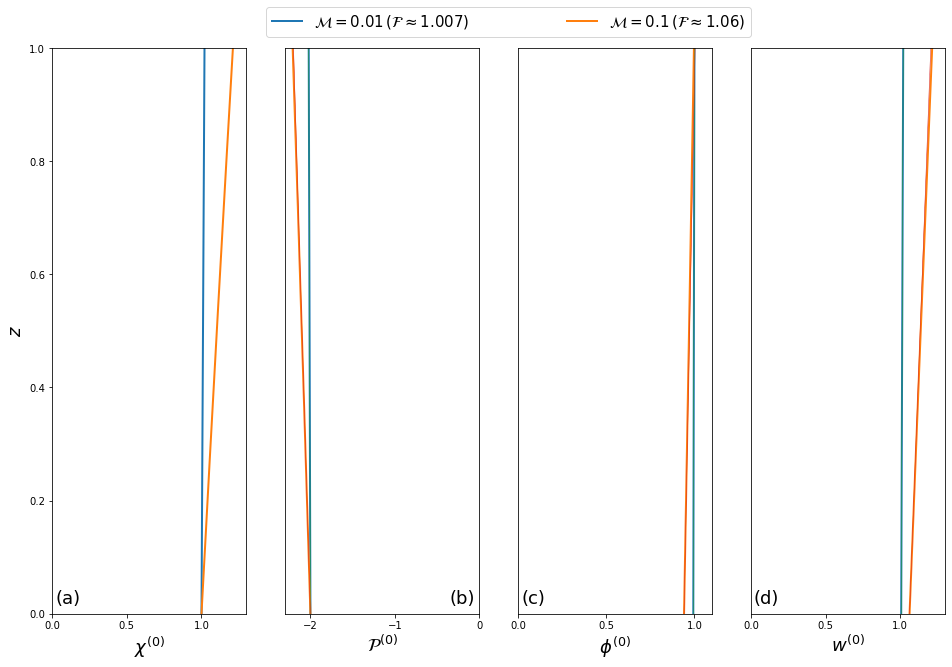

In [2]:
f, ax = plt.subplots(1, 4)
zoom = 2.0
f.set_size_inches(8.0 * zoom, 5.2 * zoom)
f.set_facecolor('w')

n = 3.0
G = 1.0
M = np.asarray([0.01, 0.1])
S = 1.0
H = 1.0
z = np.linspace(0.0, H, 1000)

F = np.power([1.0 + S*m*(1+G) for m in M], 1/n)
chi = np.asarray([(1.+G)*np.exp(m*z) - G for m in M])
cmp = -(chi + G)
phi = np.power([chij/(1.0 - S*m*cmpj) for chij, m, cmpj in zip(chi, M, cmp)], 1.0/n)
w = chi/phi
cmpl = -(1.0+G) * np.asarray([1.0 + m*z for m in M])
chil = 1.0 + np.asarray([m*(1+G)*z for m in M])
phil = np.asarray([1.0/Fj * (1.0 + m*(1.0 + G)/n*z) for Fj, m in zip(F, M)])
wl = np.asarray([Fj*(1.0 + m*(1.0+G)*(1.0-1.0/n)*z) for Fj, m in zip(F, M)])

plt.rc('axes', prop_cycle=(cycler(color=['k', 'k', 'k', 'k']) + cycler(linestyle=['-', '--', ':', '-.'])))

lines = ax[0].plot(chi.transpose(), z, linewidth=2.0)
ax[0].set_xlabel(r'$\chi^{(0)}$', fontsize=18)
ax[0].set_xlim(0.0, 1.3)
ax[0].set_xticks((0.0, 0.5, 1.0))
ax[0].set_ylabel('$z$', fontsize=18)
ax[0].set_ylim(0.0, 1.0)
ax[0].text(0.02, 0.01, '(a)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')
plt.legend(handles=(lines[0], lines[1]), 
           labels=(r'$\mathcal{M}=0.01\,(\mathcal{F}\approx1.007)$', r'$\mathcal{M}=0.1\,(\mathcal{F}\approx1.06)$'),
           fontsize=15, bbox_to_anchor=(-2.5, 1.02, 2.5, .2),
           loc='lower right', ncol=2, mode="expand", borderaxespad=0.)

ax[1].plot(cmp.transpose(), z, linewidth=2.0)
ax[1].plot(cmpl.transpose(), z, linewidth=0.5)
ax[1].set_xlabel(r'$\mathcal{P}^{(0)}$', fontsize=18)
ax[1].set_xlim(-2.3, 0.0)
ax[1].set_xticks((-2.0, -1.0, 0.0))
ax[1].set_yticks(())
ax[1].set_ylim(0.0, 1.0)
ax[1].text(-0.35, 0.01, '(b)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[2].plot(phi.transpose(), z, linewidth=2)
ax[2].plot(phil.transpose(), z, linewidth=0.5)
ax[2].set_yticks(())
ax[2].set_xlabel(r'$\phi^{(0)}$', fontsize=18)
ax[2].set_xlim(0.0, 1.1)
ax[2].set_xticks((0.0, 0.5, 1.0))
ax[2].set_ylim(0.0, 1.0)
ax[2].text(0.02, 0.01, '(c)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

ax[3].plot(w.transpose(), z, linewidth=2)
ax[3].plot(wl.transpose(), z, linewidth=0.5)
ax[3].set_xlabel(r'$w^{(0)}$', fontsize=18)
ax[3].set_yticks(())
ax[3].set_xlim(0.0, 1.3)
ax[3].set_ylim(0.0, 1.0)
ax[3].set_xticks((0.0, 0.5, 1.0))
ax[3].text(0.02, 0.01, '(d)', fontsize=18, verticalalignment='bottom', horizontalalignment='left')

plt.show()

### The growth rate of perturbations

In [3]:
class PAR:
    def __init__(self, F_=1.0, n_=3, S_=1.0, Da_=1000.0, Pe_=100.0, M_=0.01, G_=1,
                 bc_=2, nz_=1000, tol_=1e-5, plot_=False, step_=0.01, lDa=False):
        self.F = F_  # base - state parameter - force to be constant
        self.n = n_  # permeability exponent
        self.S = S_  # rigidity parameter
        self.Da = Da_  # Damkohler number
        self.Pe = Pe_  # Peclet number
        self.M = M_  # solubility gradient parameter
        self.G = G_  # decompression melting parameter
        self.bc_type = bc_  # boundary condition type -- 1) P(1)=0; 2) P'(1)=0
        self.nz = nz_  # number of points for eigenfunction
        self.tol = tol_  # tolerance
        self.plot = plot_  # plot eigenfunction
        self.step = step_  # stepsize in log10(k)--sigma space
        self.largeDa = lDa

        
class EIG:
    def __init__(self, p_=0.0, phi_=0.0):
        self.P = p_
        self.phi = phi_


class SA:
    def __init__(self, k_=0.0, sigma_=0.0, m_=0.0, flag_=False):
        self.k = k_
        self.sigma = sigma_
        self.m = m_
        self.eig = EIG()
        self.flag = flag_


class DC:
    def __init__(self, s_=0.0, k_=0.0, m_=0.0):
        self.s = s_
        self.k = k_
        self.m = m_

In [4]:
def zero_by_sigma(sig, k, par):
    m = np.roots(characteristic_polynomial(k, sig, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sig, par))
        residual = np.real((1.0 - 1.j) * detM)
    return residual


def zero_by_wavenumber(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    if par.largeDa:
        residual = np.real(m[0]) * np.sin(np.imag(m[0])) + np.imag(m[0]) * np.cos(np.imag(m[0]))
    else:
        detM = det(boundary_condition_matrix(k, m, sigma, par))
        residual = np.real((1 - 1j) * detM)
    return residual


def characteristic_polynomial(k, sig, par):
    K = k ** 2 / par.Da / par.Pe / par.F + 1.0
    p = np.asarray([0.0 if par.largeDa else sig / par.Da,  # cubic
                    sig * K - par.n * np.power(par.F, 1 + par.n) / par.Da / par.S,  # quadratic
                    -(par.n * np.power(par.F, 1 + par.n) * K / par.S + sig * k ** 2 / par.Da),  # linear
                    k ** 2 * (par.n * np.power(par.F, 1 - par.n) - sig * K)])  # constant
    return p.reshape(p.shape[0])

  
def boundary_condition_matrix(k, m, sig, par):
    if par.bc_type == 1:
        M = np.asarray([[1.0, mi, np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 2:
        M = np.asarray([[1.0, mi, mi * np.exp(mi)] for mi in m]).transpose()
    elif par.bc_type == 3:
        q = sig * par.S / par.n
        M = np.asarray([[q * mi - 1.0, q * mi ** 2 - mi - q * k ** 2, mi * np.exp(mi)] for mi in m]).transpose()
    else:
        q = k ** 2 * par.Da / par.DaPe
        M = np.asarray([[1.0 - par.S * mi, mi ** 2 + q * mi, mi * np.exp(mi)] for mi in m]).transpose()
    return M


def form_eigenfunction(k, sigma, par):
    m = np.roots(characteristic_polynomial(k, sigma, par))
    z = np.linspace(0.0, 1.0, par.nz)
    eig = EIG()
    if par.largeDa:
        eig.P = np.exp(np.real(m[0]) * z) * np.sin(np.imag(m[0]) * z)
        eig.P = eig.P / np.max(np.abs(eig.P))
        Q = (m[0] ** 2 - k ** 2) * eig.P
        eig.phi = np.power(par.F, -1.0 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    else:
        M = boundary_condition_matrix(k, m, sigma, par)
        subM = M[:, 1::]
        b = -M[:, 0]
        A = np.concatenate((np.asarray([1.0+0.j]), np.linalg.lstsq(subM, b, rcond=None)[0]))
        eig.P = np.sum(np.asarray([Aj * np.exp(mj * z) for Aj, mj in zip(A, m)]).transpose(), axis=1)
        Q = np.sum(np.asarray([(mj ** 2 - k ** 2) * Aj * np.exp(mj * z) 
                               for Aj, mj in zip(A, m)]).transpose(), axis=1)
        eig.phi = np.power(par.F, -1 - par.n) * par.S / par.n * np.cumsum(Q) * (z[1] - z[0])
    return eig

In [5]:
def reactive_flow_solve_dispersion(k_guess, sigma_guess, par):
    # input parameters:
    #   k -- horizontal wavenumber (required)
    #   sigma_guess -- guess at the eigenvalue (optional)
    #   par -- parameter structure (optional)

    sa = SA()

    if type(k_guess) is not np.ndarray:
        # solving for growthrate sigma at a fixed value of wavenumber k
        solve_for_sigma = True
        sa.k = k_guess
        if sigma_guess is None:
            sigma_guess = np.logspace(-1.0, 1.0, 100)
        if type(sigma_guess) is not np.ndarray:
            sigma_guess = np.asarray([sigma_guess])
    else:
        # solving for wavenumber k at a fixed value of growthrate sigma
        solve_for_sigma = False
        sa.sigma = sigma_guess if type(sigma_guess) is not np.ndarray else sigma_guess[0]

    if par.F is None:
        par.F = np.power(1.0 + par.S * par.M * (1.0 + par.G), 1.0 / par.n)

    sigma = np.zeros_like(sigma_guess)
    k = np.zeros_like(k_guess)
    if solve_for_sigma:
        # solve eigenvalue problem to find growth rate of fastest-growing mode
        res = np.zeros_like(sigma_guess)
        exitflag = np.zeros_like(sigma_guess)
        converged = np.zeros_like(sigma_guess)
        problem_sigma = lambda s: zero_by_sigma(s, sa.k, par)
        for j in range(len(sigma_guess)):
            [sigma[j], infodict, exitflag[j], _] = fsolve(problem_sigma, sigma_guess[j], 
                                                          full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 and np.abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(sa.k, sigma[j], par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(sa.k, sigma[j], par)
                # plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))
    else:
        # solve eigenvalue problem to find wavenumber of mode
        problem_wavenumber = lambda s: zero_by_wavenumber(s, sa.sigma, par)
        res = np.zeros_like(k_guess)
        exitflag = np.zeros_like(k_guess)
        converged = np.zeros_like(k_guess)
        for j in range(len(k_guess)):
            [k[j], infodict, exitflag[j], _] = fsolve(problem_wavenumber, k_guess[j], full_output=True, xtol=1.e-14)
            res[j] = infodict["fvec"]
            converged[j] = exitflag[j] == 1 or abs(res[j]) < par.tol
            if par.largeDa:
                m = np.roots(characteristic_polynomial(k[j], sa.sigma, par))
                converged[j] = converged[j] and np.pi / 2 < np.abs(np.imag(m[0])) < np.pi
            if par.plot and converged[j] == 1:
                eig = form_eigenfunction(k[j], sa.sigma, par)
                plt.plot(np.linspace(0.0, 1.0, par.nz), np.real(eig.P))

        # [converged', exitflag', log10(abs(res'))];
    none_converged = not np.sum(converged)

    # handle failure to find solution
    if none_converged:
        print(f'FAILURE: no solution found for k={k_guess}')
        sa.sigma = np.nan
        sa.k = np.nan
        sa.m = [np.nan, np.nan, np.nan]
        sa.eig.P = np.nan
        sa.flag = False
        return sa
    elif solve_for_sigma:
        sa.sigma = np.amax(sigma[converged != 0])
    else:
        sa.k = np.amax(k[converged != 0])

    sa.m = np.roots(characteristic_polynomial(sa.k, sa.sigma, par))

    # form and check eigenfunction
    sa.eig = form_eigenfunction(sa.k, sa.sigma, par)
    gP = np.gradient(sa.eig.P)
    # if len(np.nonzero(gP < 0)) > 1 and par.bc_type is not 1:  # TODO: check
    if (gP < 0).any() and par.bc_type != 1:
        sa.flag = False
        print(f'FAILURE: non-monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')
    else:
        sa.flag = True
        print(f'SUCCESS: monotonic eigenfunction for k={sa.k}, sigma={sa.sigma}')

    if par.plot:
        plt.plot(np.linspace(0, 1, par.nz), np.real(sa.eig.P), linewidth=2)

    return sa

In [6]:
def taylor_series_extension(n, x, y, step, init_Lks):
    if n == 0:
        xguess = init_Lks[0]
        yguess = init_Lks[1]
    elif n == 1:
        xguess = x[0]-step
        yguess = y[0]
    elif n == 2:
        d = np.asarray([x[1]-x[0], y[1]-y[0]])
        d = d/np.sqrt(np.sum(d**2))
        xguess = x[-1] + d[0]*step
        yguess = y[-1] + d[1]*step
    else:
        da = np.asarray([x[-1]-x[-2], y[-1]-y[-2]])
        db = np.asarray([x[-2]-x[-3], y[-2]-y[-3]])
        D = 0.5*(np.sqrt(np.sum(da**2)) + np.sqrt(np.sum(db**2)))
        da = da/np.sqrt(np.sum(da**2))
        db = db/np.sqrt(np.sum(db**2))
        d2 = (da - db)/D
        xguess = x[-1] + da[0]*step + 0.5*d2[0]*step**2
        yguess = y[-1] + da[1]*step + 0.5*d2[1]*step**2

    if np.isinf(xguess) or np.isnan(xguess):
        xguess = x[-1]
    if np.isinf(yguess) or np.isnan(yguess):
        yguess = y[-1]

    return xguess, yguess

In [7]:
def reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks):
    n = 0  # can n be zero?
    Lk = np.full((1, ), np.inf)  # dictionaries
    s = np.full((1, ), np.inf)
    m = np.full((1, 3), np.inf + 0.j, dtype=np.complex)

    for j in [0, 1]:
        fails = 0
        while n < 1_000_000:
            Lk_guess, s_guess = taylor_series_extension(n, Lk, s, par.step, init_Lks)
            if Lk_guess <= Lkbounds[0] or Lk_guess >= Lkbounds[1]:
                break
            if s_guess <= sbounds[0] or s_guess >= sbounds[1]:
                break

            if n == 0:
                s_guess = np.linspace(0.1, par.n, 30)
            elif fails <= 1:
                print(f'Iteration {n}: searching for solution at k={np.power(10, Lk_guess)}')
                s_guess = s_guess * np.linspace(0.99, 1.01, 16)
            elif fails == 2:
                print(f'Iteration {n}: searching for solution at sigma={s_guess}')
                Lk_guess = Lk_guess * np.linspace(0.99, 1.01, 16)
            else:
                break

            sa = reactive_flow_solve_dispersion(np.power(10., Lk_guess), s_guess, par)

            if sa.flag:
                # found lowest mode; prepare for next iteration
                if n == 0:
                    Lk[n] = np.log10(sa.k)
                    s[n] = sa.sigma
                    m[n] = sa.m
                else:
                    Lk = np.concatenate((Lk, np.asarray([np.log10(sa.k)])))
                    s = np.concatenate((s, np.asarray([sa.sigma])))
                    m = np.concatenate((m, np.asarray([sa.m])))
                n = n + 1
                fails = 0
            else:
                # found higher mode; retry
                fails = fails + 1

        if j == 0:
            s = np.flip(s)
            Lk = np.flip(Lk)
            m = np.flipud(m)

    return DC(s, np.power(10., Lk), m)

In [8]:
par = PAR()

Lkbounds = np.log10([0.1, 400.0])
sbounds = np.asarray([0.05, 4.0])
init_Lks = np.asarray([np.log10(5.0), 3.0])

DC_ref = reactive_flow_trace_dispersion_curve(par, Lkbounds, sbounds, init_Lks)
iref = np.argmax(DC_ref.s)

dpar = par
dpar.Da = 10.0
DC_a = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)
dpar.Da = 100.0
DC_b = reactive_flow_trace_dispersion_curve(dpar, Lkbounds, sbounds, init_Lks)

SUCCESS: monotonic eigenfunction for k=5.000000000000001, sigma=2.596489830144003
Iteration 1: searching for solution at k=4.886186104779054
SUCCESS: monotonic eigenfunction for k=4.886186104779054, sigma=2.5793461640905706
Iteration 2: searching for solution at k=4.8298258486684915
SUCCESS: monotonic eigenfunction for k=4.8298258486684915, sigma=2.57045525456229
Iteration 3: searching for solution at k=4.77570019745004
SUCCESS: monotonic eigenfunction for k=4.77570019745004, sigma=2.5616530658570715
Iteration 4: searching for solution at k=4.7229374259332095
SUCCESS: monotonic eigenfunction for k=4.7229374259332095, sigma=2.5528139088490143
Iteration 5: searching for solution at k=4.671485390538257
SUCCESS: monotonic eigenfunction for k=4.671485390538257, sigma=2.54393896356508
Iteration 6: searching for solution at k=4.621296646934616
SUCCESS: monotonic eigenfunction for k=4.621296646934616, sigma=2.5350297549011778
Iteration 7: searching for solution at k=4.572325718222083
SUCCESS: 

SUCCESS: monotonic eigenfunction for k=3.000457893037922, sigma=2.0267600962606216
Iteration 61: searching for solution at k=2.9821028283150945
SUCCESS: monotonic eigenfunction for k=2.9821028283150945, sigma=2.0170835844534043
Iteration 62: searching for solution at k=2.9639939824961408
SUCCESS: monotonic eigenfunction for k=2.9639939824961408, sigma=2.0074020604547544
Iteration 63: searching for solution at k=2.946125959445914
SUCCESS: monotonic eigenfunction for k=2.946125959445914, sigma=1.9977156497515944
Iteration 64: searching for solution at k=2.9284935300215
SUCCESS: monotonic eigenfunction for k=2.9284935300215, sigma=1.9880244732748926
Iteration 65: searching for solution at k=2.911091625927486
SUCCESS: monotonic eigenfunction for k=2.911091625927486, sigma=1.9783286475808557
Iteration 66: searching for solution at k=2.893915333841757
SUCCESS: monotonic eigenfunction for k=2.893915333841757, sigma=1.9686282850231809
Iteration 67: searching for solution at k=2.876959889798782

SUCCESS: monotonic eigenfunction for k=2.198608429974093, sigma=1.4301860311836299
Iteration 122: searching for solution at k=2.189302954195696
SUCCESS: monotonic eigenfunction for k=2.189302954195696, sigma=1.4203283756343439
Iteration 123: searching for solution at k=2.180088907719179
SUCCESS: monotonic eigenfunction for k=2.180088907719179, sigma=1.4104686407760079
Iteration 124: searching for solution at k=2.1709654269636625
SUCCESS: monotonic eigenfunction for k=2.1709654269636625, sigma=1.4006068249236672
Iteration 125: searching for solution at k=2.161931681598373
SUCCESS: monotonic eigenfunction for k=2.161931681598373, sigma=1.3907429250168655
Iteration 126: searching for solution at k=2.1529868742620373
SUCCESS: monotonic eigenfunction for k=2.1529868742620373, sigma=1.3808769365975595
Iteration 127: searching for solution at k=2.1441302403165734
SUCCESS: monotonic eigenfunction for k=2.1441302403165734, sigma=1.3710088537856233
Iteration 128: searching for solution at k=2.13

SUCCESS: monotonic eigenfunction for k=1.8022273167477263, sigma=0.8641181389042176
Iteration 179: searching for solution at k=1.7977898907047465
SUCCESS: monotonic eigenfunction for k=1.7977898907047465, sigma=0.8540649216851127
Iteration 180: searching for solution at k=1.7934573770581845
SUCCESS: monotonic eigenfunction for k=1.7934573770581845, sigma=0.8440033051194522
Iteration 181: searching for solution at k=1.789231921433876
SUCCESS: monotonic eigenfunction for k=1.789231921433876, sigma=0.8339327226432995
Iteration 182: searching for solution at k=1.7851158060094738
SUCCESS: monotonic eigenfunction for k=1.7851158060094738, sigma=0.8238525376988776
Iteration 183: searching for solution at k=1.7811114581620757
SUCCESS: monotonic eigenfunction for k=1.7811114581620757, sigma=0.8137620312321754
Iteration 184: searching for solution at k=1.7772214599445333
SUCCESS: monotonic eigenfunction for k=1.7772214599445333, sigma=0.8036603862297201
Iteration 185: searching for solution at k

SUCCESS: monotonic eigenfunction for k=1.8733767541244355, sigma=0.3125668783559171
Iteration 235: searching for solution at k=1.8872645342547272
SUCCESS: monotonic eigenfunction for k=1.8872645342547272, sigma=0.3034075073761858
Iteration 236: searching for solution at k=1.9021210169942402
SUCCESS: monotonic eigenfunction for k=1.9021210169942402, sigma=0.2943114912123439
Iteration 237: searching for solution at k=1.9179962823287162
SUCCESS: monotonic eigenfunction for k=1.9179962823287162, sigma=0.285286140682754
Iteration 238: searching for solution at k=1.9349416724183848
SUCCESS: monotonic eigenfunction for k=1.9349416724183848, sigma=0.2763392029513724
Iteration 239: searching for solution at k=1.9530095021639347
SUCCESS: monotonic eigenfunction for k=1.9530095021639347, sigma=0.2674788464232898
Iteration 240: searching for solution at k=1.9722527152480793
SUCCESS: monotonic eigenfunction for k=1.9722527152480793, sigma=0.25871363159658883
Iteration 241: searching for solution at

SUCCESS: monotonic eigenfunction for k=3.3866699643226283, sigma=0.0697777081580978
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at k=3.4614471748521556
FAILURE: no solution found for k=3.4614471748521556
Iteration 272: searching for solution at sigma=0.06660635029342152
FAILURE: non-monotonic eigenfunction for k=3.5538366738626475, sigma=0.06660635029342152
Iteration 272: searching for solution at k=5.058765018033284
SUCCESS: monotonic eigenfunction for k=5.058765018033284, sigma=2.604939080674623
Iteration 273: searching for solution at k=5.119531639910905
SUCCESS: monotonic eigenfunction for k=5.119531639910905, sigma=2.613402987083552
Iteration 274: searching for solution at k=5.181944312819961
SUCCESS: monotonic eigenfunction for k=5.181944312819961, sigma=2.621818793611423
Iteration 275: searching for solution at k=5.246065810533805
SUCCESS: monotonic eigenfunction for k=5.2

SUCCESS: monotonic eigenfunction for k=13.925392063090193, sigma=2.934755273948965
Iteration 330: searching for solution at k=14.241759614198674
SUCCESS: monotonic eigenfunction for k=14.241759614198674, sigma=2.9368941916783893
Iteration 331: searching for solution at k=14.566141043087281
SUCCESS: monotonic eigenfunction for k=14.566141043087281, sigma=2.938922187603193
Iteration 332: searching for solution at k=14.898691378290142
SUCCESS: monotonic eigenfunction for k=14.898691378290142, sigma=2.9408418539304773
Iteration 333: searching for solution at k=15.239570028559925
SUCCESS: monotonic eigenfunction for k=15.239570028559925, sigma=2.9426557367103476
Iteration 334: searching for solution at k=15.588940918361198
SUCCESS: monotonic eigenfunction for k=15.588940918361198, sigma=2.9443663238756232
Iteration 335: searching for solution at k=15.946972608494585
SUCCESS: monotonic eigenfunction for k=15.946972608494585, sigma=2.9459760344852417
Iteration 336: searching for solution at k

SUCCESS: monotonic eigenfunction for k=51.01369828653325, sigma=2.9146864810531894
Iteration 387: searching for solution at k=52.142402781952036
SUCCESS: monotonic eigenfunction for k=52.142402781952036, sigma=2.9115001789947015
Iteration 388: searching for solution at k=53.2906444691081
SUCCESS: monotonic eigenfunction for k=53.2906444691081, sigma=2.908179721388645
Iteration 389: searching for solution at k=54.45826409112588
SUCCESS: monotonic eigenfunction for k=54.45826409112588, sigma=2.90472303986449
Iteration 390: searching for solution at k=55.64506018022055
SUCCESS: monotonic eigenfunction for k=55.64506018022055, sigma=2.901128227284932
Iteration 391: searching for solution at k=56.850788138841494
SUCCESS: monotonic eigenfunction for k=56.850788138841494, sigma=2.897393558667636
Iteration 392: searching for solution at k=58.075159699949005
SUCCESS: monotonic eigenfunction for k=58.075159699949005, sigma=2.89351751138396
Iteration 393: searching for solution at k=59.3178428077

SUCCESS: monotonic eigenfunction for k=113.0212437933895, sigma=2.6506072457752374
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at k=114.54445649559281
FAILURE: non-monotonic eigenfunction for k=114.54445649559281, sigma=2.6375972328608928
Iteration 428: searching for solution at sigma=2.6424706169308965
SUCCESS: monotonic eigenfunction for k=114.80873325435238, sigma=2.6424706169308965
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at k=116.59056064581878
FAILURE: non-monotonic eigenfunction for k=116.59056064581878, sigma=2.6266233562252777
Iteration 429: searching for solution at sigma=2.6350125559423137
SUCCESS: monotonic eigenfunction for k=116.17308946850954, sigma=2.6350125559423137
Iteration 430: se

FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at k=146.28752402992941
FAILURE: non-monotonic eigenfunction for k=146.28752402992941, sigma=2.445144072144583
Iteration 449: searching for solution at sigma=2.461082862448662
SUCCESS: monotonic eigenfunction for k=146.27784770465396, sigma=2.461082862448662
Iteration 450: searching for solution at k=147.77748323071222
FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at k=147.77748323071222
FAILURE: non-monotonic eigenfunction for k=147.77748323071222, sigma=2.436530184032015
Iteration 450: searching for solution at sigma=2.4521173824742863
SUCCESS: monotonic eigenfunction for k=147.76799837903738, sigma=2.4521173824742863
Iteration 451: searching for solution at k=149.2672252707073
FAILURE: no solution found for k=149.2672252707073
Iteration 451: searching for solution at k=149.267225270

FAILURE: no solution found for k=177.63919005977095
Iteration 470: searching for solution at sigma=2.269026146457919
SUCCESS: monotonic eigenfunction for k=177.63272400440943, sigma=2.269026146457919
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at k=179.14226301666838
FAILURE: no solution found for k=179.14226301666838
Iteration 471: searching for solution at sigma=2.2597259062004373
SUCCESS: monotonic eigenfunction for k=179.13591575553485, sigma=2.2597259062004373
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at k=180.6469873590286
FAILURE: no solution found for k=180.6469873590286
Iteration 472: searching for solution at sigma=2.2504150338263993
SUCCESS: monotonic eigenfunction for k=180.64075652723272, sigma=2.2504150338263993
Iteration 473: searching for solution at k=182.1

FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at k=212.80913689473732
FAILURE: no solution found for k=212.80913689473732
Iteration 493: searching for solution at sigma=2.0529462006440293
SUCCESS: monotonic eigenfunction for k=212.8049296766982, sigma=2.0529462006440293
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at k=214.37638358690654
FAILURE: no solution found for k=214.37638358690654
Iteration 494: searching for solution at sigma=2.0434704131674417
SUCCESS: monotonic eigenfunction for k=214.37225770040592, sigma=2.0434704131674417
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at k=215.9477136042225
FAILURE: no solution found for k=215.9477136042225
Iteration 495: searching for solution at sigma=2.033989505070598
SUCCESS: monotonic

FAILURE: no solution found for k=248.41255122280003
Iteration 515: searching for solution at sigma=1.8435082400057907
SUCCESS: monotonic eigenfunction for k=248.40996843644723, sigma=1.8435082400057907
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at k=250.09720331699543
FAILURE: no solution found for k=250.09720331699543
Iteration 516: searching for solution at sigma=1.833950125986671
SUCCESS: monotonic eigenfunction for k=250.0946892172906, sigma=1.833950125986671
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at k=251.78866041983363
FAILURE: no solution found for k=251.78866041983363
Iteration 517: searching for solution at sigma=1.8243895190841657
SUCCESS: monotonic eigenfunction for k=251.7862148270454, sigma=1.8243895190841657
Iteration 518: searching for solution at k=253

FAILURE: no solution found for k=287.2740612571062
Iteration 537: searching for solution at sigma=1.6327802064027062
SUCCESS: monotonic eigenfunction for k=287.27299665937466, sigma=1.6327802064027062
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at k=289.14343819803884
FAILURE: no solution found for k=289.14343819803884
Iteration 538: searching for solution at sigma=1.6231856317886395
SUCCESS: monotonic eigenfunction for k=289.14244567287375, sigma=1.6231856317886395
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at k=291.02314614803197
FAILURE: no solution found for k=291.02314614803197
Iteration 539: searching for solution at sigma=1.6135902190271625
SUCCESS: monotonic eigenfunction for k=291.0222262309512, sigma=1.6135902190271625
Iteration 540: searching for solution at k=2

SUCCESS: monotonic eigenfunction for k=3.4449573317601287, sigma=1.6394890477713298
Iteration 37: searching for solution at k=3.4192483024487927
SUCCESS: monotonic eigenfunction for k=3.4192483024487927, sigma=1.6299712058856088
Iteration 38: searching for solution at k=3.3940290093212235
SUCCESS: monotonic eigenfunction for k=3.3940290093212235, sigma=1.6204412978336613
Iteration 39: searching for solution at k=3.3692837706673684
SUCCESS: monotonic eigenfunction for k=3.3692837706673684, sigma=1.610899783209625
Iteration 40: searching for solution at k=3.3449976666563783
SUCCESS: monotonic eigenfunction for k=3.3449976666563783, sigma=1.6013470943754358
Iteration 41: searching for solution at k=3.3211564933346174
SUCCESS: monotonic eigenfunction for k=3.3211564933346174, sigma=1.5917836383520547
Iteration 42: searching for solution at k=3.2977467200671433
SUCCESS: monotonic eigenfunction for k=3.2977467200671433, sigma=1.5822097985471903
Iteration 43: searching for solution at k=3.274

SUCCESS: monotonic eigenfunction for k=2.446244210320908, sigma=1.0452735494206293
Iteration 98: searching for solution at k=2.4364072545507005
SUCCESS: monotonic eigenfunction for k=2.4364072545507005, sigma=1.0353616145864417
Iteration 99: searching for solution at k=2.4267350893217277
SUCCESS: monotonic eigenfunction for k=2.4267350893217277, sigma=1.0254439954522454
Iteration 100: searching for solution at k=2.417227638952335
SUCCESS: monotonic eigenfunction for k=2.417227638952335, sigma=1.0155205700189511
Iteration 101: searching for solution at k=2.4078849564571914
SUCCESS: monotonic eigenfunction for k=2.4078849564571914, sigma=1.0055912047728603
Iteration 102: searching for solution at k=2.3987072263884013
SUCCESS: monotonic eigenfunction for k=2.3987072263884013, sigma=0.9956557537300296
Iteration 103: searching for solution at k=2.3896947680351004
SUCCESS: monotonic eigenfunction for k=2.3896947680351004, sigma=0.9857140573459586
Iteration 104: searching for solution at k=2.

SUCCESS: monotonic eigenfunction for k=2.225467103843091, sigma=0.48685866668045585
Iteration 154: searching for solution at k=2.231423321112713
SUCCESS: monotonic eigenfunction for k=2.231423321112713, sigma=0.4774224678591187
Iteration 155: searching for solution at k=2.23803499987153
SUCCESS: monotonic eigenfunction for k=2.23803499987153, sigma=0.46797771771333624
Iteration 156: searching for solution at k=2.2453376147818838
SUCCESS: monotonic eigenfunction for k=2.2453376147818838, sigma=0.45852987921482274
Iteration 157: searching for solution at k=2.2533686569024436
SUCCESS: monotonic eigenfunction for k=2.2533686569024436, sigma=0.449084129712734
Iteration 158: searching for solution at k=2.262167729557545
SUCCESS: monotonic eigenfunction for k=2.262167729557545, sigma=0.4396455014652541
Iteration 159: searching for solution at k=2.2717766275177858
SUCCESS: monotonic eigenfunction for k=2.2717766275177858, sigma=0.4302189931065886
Iteration 160: searching for solution at k=2.28

FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at k=4.632178682510815
FAILURE: no solution found for k=4.632178682510815
Iteration 207: searching for solution at sigma=0.10724420478043752
SUCCESS: monotonic eigenfunction for k=4.6341584150855315, sigma=0.10724420478043752
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at k=4.736604438510556
FAILURE: no solution found for k=4.736604438510556
Iteration 208: searching for solution at sigma=0.10410855944043974
SUCCESS: monotonic eigenfunction for k=4.738609289546041, sigma=0.10410855944043974
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at k=4.843755236802824
FAILURE: no solution found for k=4.843755236802824
Iteration 209: searching for solution at sigma=0.10108126738417506
SUCCESS: monotonic 

SUCCESS: monotonic eigenfunction for k=9.917279173631444, sigma=1.998064532295171
Iteration 250: searching for solution at k=10.085980268799723
SUCCESS: monotonic eigenfunction for k=10.085980268799723, sigma=1.9910990510961424
Iteration 251: searching for solution at k=10.253779804016425
SUCCESS: monotonic eigenfunction for k=10.253779804016425, sigma=1.983974307231853
Iteration 252: searching for solution at k=10.420736707531228
SUCCESS: monotonic eigenfunction for k=10.420736707531228, sigma=1.9767052263224156
Iteration 253: searching for solution at k=10.586912798385175
SUCCESS: monotonic eigenfunction for k=10.586912798385175, sigma=1.9693049798989202
Iteration 254: searching for solution at k=10.752371189790955
SUCCESS: monotonic eigenfunction for k=10.752371189790955, sigma=1.9617852166349823
Iteration 255: searching for solution at k=10.917175145355332
SUCCESS: monotonic eigenfunction for k=10.917175145355332, sigma=1.9541562632229745
Iteration 256: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=19.493267708596708, sigma=1.5097855715897297
Iteration 307: searching for solution at k=19.679330027274073
SUCCESS: monotonic eigenfunction for k=19.679330027274073, sigma=1.5006585906780454
Iteration 308: searching for solution at k=19.866547616532074
SUCCESS: monotonic eigenfunction for k=19.866547616532074, sigma=1.491526204602572
Iteration 309: searching for solution at k=20.054946715690225
SUCCESS: monotonic eigenfunction for k=20.054946715690225, sigma=1.482388687185728
Iteration 310: searching for solution at k=20.244553804733687
SUCCESS: monotonic eigenfunction for k=20.244553804733687, sigma=1.4732463034294048
Iteration 311: searching for solution at k=20.435395622471802
SUCCESS: monotonic eigenfunction for k=20.435395622471802, sigma=1.464099310047147
Iteration 312: searching for solution at k=20.62749918462688
SUCCESS: monotonic eigenfunction for k=20.62749918462688, sigma=1.4549479559639416
Iteration 313: searching for solution at k=20

FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at k=31.97452788509629
FAILURE: no solution found for k=31.97452788509629
Iteration 360: searching for solution at sigma=1.0036122481152505
SUCCESS: monotonic eigenfunction for k=32.916719489529655, sigma=1.0036122481152505
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at k=33.64029494004599
FAILURE: no solution found for k=33.64029494004599
Iteration 361: searching for solution at sigma=0.9981211918258368
SUCCESS: monotonic eigenfunction for k=33.09312462894401, sigma=0.9981211918258368
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at k=33.258627153937006
FAILURE: no solution found for k=33.258627153937006
Iteration 362: searching for solution at sigma=0.9876291888950754
SUCCESS: monotonic e

FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at k=41.36561260359658
FAILURE: no solution found for k=41.36561260359658
Iteration 383: searching for solution at sigma=0.7813999135109416
SUCCESS: monotonic eigenfunction for k=41.36691811792117, sigma=0.7813999135109416
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at k=41.77895880454644
FAILURE: no solution found for k=41.77895880454644
Iteration 384: searching for solution at sigma=0.7723737191799279
SUCCESS: monotonic eigenfunction for k=41.78031070216377, sigma=0.7723737191799279
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at k=42.19866448665221
FAILURE: no solution found for k=42.19866448665221
Iteration 385: searching for solution at sigma=0.7633583337915671
SUCCESS: monotonic eigenf

SUCCESS: monotonic eigenfunction for k=4.619265469799113, sigma=2.4878339778490455
Iteration 7: searching for solution at k=4.570019218340134
SUCCESS: monotonic eigenfunction for k=4.570019218340134, sigma=2.4789039547738376
Iteration 8: searching for solution at k=4.521980059751317
SUCCESS: monotonic eigenfunction for k=4.521980059751317, sigma=2.469941055849282
Iteration 9: searching for solution at k=4.475103343065708
SUCCESS: monotonic eigenfunction for k=4.475103343065708, sigma=2.4609467315055076
Iteration 10: searching for solution at k=4.42934643217941
SUCCESS: monotonic eigenfunction for k=4.42934643217941, sigma=2.451922356117799
Iteration 11: searching for solution at k=4.3846686094336444
SUCCESS: monotonic eigenfunction for k=4.3846686094336444, sigma=2.442869232264257
Iteration 12: searching for solution at k=4.341030983140733
SUCCESS: monotonic eigenfunction for k=4.341030983140733, sigma=2.433788594761939
Iteration 13: searching for solution at k=4.298396399048338
SUCCES

SUCCESS: monotonic eigenfunction for k=2.927172486094001, sigma=1.9408193829594305
Iteration 65: searching for solution at k=2.909836689764269
SUCCESS: monotonic eigenfunction for k=2.909836689764269, sigma=1.9311209495749375
Iteration 66: searching for solution at k=2.892726262811575
SUCCESS: monotonic eigenfunction for k=2.892726262811575, sigma=1.9214179725323643
Iteration 67: searching for solution at k=2.8758364485924126
SUCCESS: monotonic eigenfunction for k=2.8758364485924126, sigma=1.911710559487104
Iteration 68: searching for solution at k=2.859162636183551
SUCCESS: monotonic eigenfunction for k=2.859162636183551, sigma=1.9019988141416473
Iteration 69: searching for solution at k=2.8427003551232595
SUCCESS: monotonic eigenfunction for k=2.8427003551232595, sigma=1.8922828363976643
Iteration 70: searching for solution at k=2.8264452703855163
SUCCESS: monotonic eigenfunction for k=2.8264452703855163, sigma=1.882562722500488
Iteration 71: searching for solution at k=2.81039317757

SUCCESS: monotonic eigenfunction for k=2.2013155416373875, sigma=1.3827805051831243
Iteration 122: searching for solution at k=2.192104458329351
SUCCESS: monotonic eigenfunction for k=2.192104458329351, sigma=1.3729171607107056
Iteration 123: searching for solution at k=2.182986586834206
SUCCESS: monotonic eigenfunction for k=2.182986586834206, sigma=1.3630515939453394
Iteration 124: searching for solution at k=2.1739611341947156
SUCCESS: monotonic eigenfunction for k=2.1739611341947156, sigma=1.3531837977055288
Iteration 125: searching for solution at k=2.165027342944505
SUCCESS: monotonic eigenfunction for k=2.165027342944505, sigma=1.3433137632057215
Iteration 126: searching for solution at k=2.1561844909321883
SUCCESS: monotonic eigenfunction for k=2.1561844909321883, sigma=1.3334414800210321
Iteration 127: searching for solution at k=2.147431891185212
SUCCESS: monotonic eigenfunction for k=2.147431891185212, sigma=1.3235669360484679
Iteration 128: searching for solution at k=2.138

SUCCESS: monotonic eigenfunction for k=1.812926244891896, sigma=0.8056384986379524
Iteration 180: searching for solution at k=1.8090739869390957
SUCCESS: monotonic eigenfunction for k=1.8090739869390957, sigma=0.7955201327781608
Iteration 181: searching for solution at k=1.8053476314231671
SUCCESS: monotonic eigenfunction for k=1.8053476314231671, sigma=0.7853880265400512
Iteration 182: searching for solution at k=1.8017504662678927
SUCCESS: monotonic eigenfunction for k=1.8017504662678927, sigma=0.7752408428246811
Iteration 183: searching for solution at k=1.7982859982119757
SUCCESS: monotonic eigenfunction for k=1.7982859982119757, sigma=0.7650770101729556
Iteration 184: searching for solution at k=1.794957970424165
SUCCESS: monotonic eigenfunction for k=1.794957970424165, sigma=0.7548946632381415
Iteration 185: searching for solution at k=1.7917703825519051
SUCCESS: monotonic eigenfunction for k=1.7917703825519051, sigma=0.7446915630254882
Iteration 186: searching for solution at k=

SUCCESS: monotonic eigenfunction for k=1.9651836514121956, sigma=0.2898541205148497
Iteration 233: searching for solution at k=1.9830867123667266
SUCCESS: monotonic eigenfunction for k=1.9830867123667266, sigma=0.28095596630256353
Iteration 234: searching for solution at k=2.0021717826804615
SUCCESS: monotonic eigenfunction for k=2.0021717826804615, sigma=0.27214971946313776
Iteration 235: searching for solution at k=2.022493528462039
SUCCESS: monotonic eigenfunction for k=2.022493528462039, sigma=0.26344426324026476
Iteration 236: searching for solution at k=2.0441065576354913
SUCCESS: monotonic eigenfunction for k=2.0441065576354913, sigma=0.2548487986730637
Iteration 237: searching for solution at k=2.0670649269753394
SUCCESS: monotonic eigenfunction for k=2.0670649269753394, sigma=0.2463727700969805
Iteration 238: searching for solution at k=2.0914216186627606
SUCCESS: monotonic eigenfunction for k=2.0914216186627606, sigma=0.23802577244553563
Iteration 239: searching for solution 

SUCCESS: monotonic eigenfunction for k=6.711450137040172, sigma=2.712536940408047
Iteration 283: searching for solution at k=6.8246709712386275
SUCCESS: monotonic eigenfunction for k=6.8246709712386275, sigma=2.719289451208433
Iteration 284: searching for solution at k=6.941710794110687
SUCCESS: monotonic eigenfunction for k=6.941710794110687, sigma=2.725912390786907
Iteration 285: searching for solution at k=7.062712816277292
SUCCESS: monotonic eigenfunction for k=7.062712816277292, sigma=2.732400286601157
Iteration 286: searching for solution at k=7.187822703270551
SUCCESS: monotonic eigenfunction for k=7.187822703270551, sigma=2.7387475681572626
Iteration 287: searching for solution at k=7.317188185550247
SUCCESS: monotonic eigenfunction for k=7.317188185550247, sigma=2.7449485865900374
Iteration 288: searching for solution at k=7.450958626043891
SUCCESS: monotonic eigenfunction for k=7.450958626043891, sigma=2.750997636688746
Iteration 289: searching for solution at k=7.58928454839

SUCCESS: monotonic eigenfunction for k=22.84167879848014, sigma=2.7689380443902656
Iteration 341: searching for solution at k=23.288329321454658
SUCCESS: monotonic eigenfunction for k=23.288329321454658, sigma=2.7634033599337484
Iteration 342: searching for solution at k=23.73757972632302
SUCCESS: monotonic eigenfunction for k=23.73757972632302, sigma=2.7576991888630493
Iteration 343: searching for solution at k=24.189186584961035
SUCCESS: monotonic eigenfunction for k=24.189186584961035, sigma=2.7518313506325303
Iteration 344: searching for solution at k=24.64291540081613
SUCCESS: monotonic eigenfunction for k=24.64291540081613, sigma=2.7458056939652056
Iteration 345: searching for solution at k=25.098541625531613
SUCCESS: monotonic eigenfunction for k=25.098541625531613, sigma=2.7396280669815214
Iteration 346: searching for solution at k=25.55585148456446
SUCCESS: monotonic eigenfunction for k=25.55585148456446, sigma=2.7333042890675396
Iteration 347: searching for solution at k=26.0

SUCCESS: monotonic eigenfunction for k=49.572732991661745, sigma=2.3017621799097534
Iteration 399: searching for solution at k=50.035028317408646
SUCCESS: monotonic eigenfunction for k=50.035028317408646, sigma=2.2925659565563032
Iteration 400: searching for solution at k=50.49777052084663
SUCCESS: monotonic eigenfunction for k=50.49777052084663, sigma=2.2833560344109602
Iteration 401: searching for solution at k=50.9609933280614
SUCCESS: monotonic eigenfunction for k=50.9609933280614, sigma=2.274132911873126
Iteration 402: searching for solution at k=51.42473055638525
SUCCESS: monotonic eigenfunction for k=51.42473055638525, sigma=2.2648970659714958
Iteration 403: searching for solution at k=51.889016105444135
SUCCESS: monotonic eigenfunction for k=51.889016105444135, sigma=2.2556489534772646
Iteration 404: searching for solution at k=52.353883950069545
SUCCESS: monotonic eigenfunction for k=52.353883950069545, sigma=2.246389011953355
Iteration 405: searching for solution at k=52.8193

FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at k=65.52206336688049
FAILURE: no solution found for k=65.52206336688049
Iteration 429: searching for solution at sigma=1.983174105043481
SUCCESS: monotonic eigenfunction for k=66.02471969093658, sigma=1.983174105043481
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at k=66.86660370683
FAILURE: no solution found for k=66.86660370683
Iteration 430: searching for solution at sigma=1.9746217553498444
SUCCESS: monotonic eigenfunction for k=66.46999510760034, sigma=1.9746217553498444
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at k=66.86259097341457
FAILURE: no solution found for k=66.86259097341457
Iteration 431: searching for solution at sigma=1.9648713389604793
SUCCESS: monotonic eigenfunction for k=

FAILURE: no solution found for k=77.28731120959205
Iteration 451: searching for solution at sigma=1.7748146357328265
SUCCESS: monotonic eigenfunction for k=77.28666580467488, sigma=1.7748146357328265
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at k=77.82686369219385
FAILURE: no solution found for k=77.82686369219385
Iteration 452: searching for solution at sigma=1.765283126336854
SUCCESS: monotonic eigenfunction for k=77.82623853313093, sigma=1.765283126336854
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at k=78.36904075536569
FAILURE: no solution found for k=78.36904075536569
Iteration 453: searching for solution at sigma=1.7557495670391912
SUCCESS: monotonic eigenfunction for k=78.36843586240371, sigma=1.7557495670391912
Iteration 454: searching for solution at k=78.9138893920

FAILURE: no solution found for k=90.4508261122974
Iteration 474: searching for solution at sigma=1.5552078134832152
SUCCESS: monotonic eigenfunction for k=90.45066869733338, sigma=1.5552078134832152
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at k=91.06399397091998
FAILURE: no solution found for k=91.06399397091998
Iteration 475: searching for solution at sigma=1.54564819567285
SUCCESS: monotonic eigenfunction for k=91.06385978431278, sigma=1.54564819567285
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at k=91.68107360841375
FAILURE: no solution found for k=91.68107360841375
Iteration 476: searching for solution at sigma=1.5360881862515803
SUCCESS: monotonic eigenfunction for k=91.68096291228409, sigma=1.5360881862515803
Iteration 477: searching for solution at k=92.3021331123779

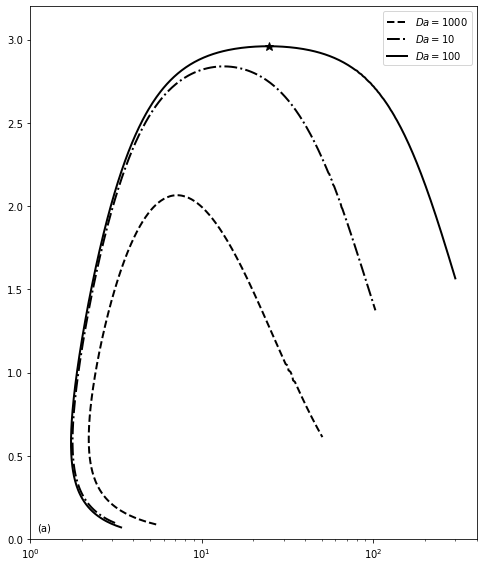

In [9]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(4.0 * zoom, 4.9 * zoom)
f.set_facecolor('w')

ax.plot(DC_a.k, DC_a.s, '--k', linewidth=2, label=r'$Da=1000$')
ax.plot(DC_b.k, DC_b.s, '-.k', linewidth=2, label=r'$Da=10$')
ax.plot(DC_ref.k, DC_ref.s, '-k', linewidth=2, label=r'$Da=100$')
ax.plot(DC_ref.k[iref], DC_ref.s[iref], '*k', MarkerSize=9)
ax.set_xscale('log')
ax.set_xlim(1.0, 400.0)
ax.set_xticks((1e0, 1e1, 1e2))
ax.set_ylim(0.0, 3.2)
ax.text(1.1, 0.1, '(a)', verticalalignment='top', horizontalalignment='left')
plt.legend()
plt.show()

In [10]:
DC_ref.k[iref], DC_ref.s[iref]

(24.655561068701545, 2.9598758196773103)

In [11]:
k_iref, s_iref = DC_ref.k[iref], DC_ref.s[iref]
SA_ref = reactive_flow_solve_dispersion(k_iref, s_iref, PAR())

lambda_ = 2.0 * np.pi/k_iref
X, Z = np.meshgrid(np.linspace(0.0, 2.0 * lambda_, par.nz), np.linspace(0.0, 1.0, par.nz))
P = np.tile(SA_ref.eig.P, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
phi = np.tile(SA_ref.eig.phi, (par.nz, 1)).transpose() * np.exp(1j * k_iref * X)
epsilon = 3e-5
h = 1.0/(par.nz-1.0)
Px, Pz = np.gradient(P, h, h)
F = par.F
U = epsilon * np.real(-np.power(F, 1 - par.n) * par.S * Px)
W = F + epsilon * np.real(F**2 * (par.n-1) * phi - np.power(F, 1 - par.n) * par.S * Pz)
Chi = s_iref * phi - P

P = np.real(P)
P = (P - np.amin(P))/(np.amax(P) - np.amin(P))
phi = np.real(phi)
phi = (phi - np.amin(phi))/(np.amax(phi) - np.amin(phi))
Chi = np.real(Chi)
Chi = (Chi - np.amin(Chi))/(np.amax(Chi) - np.amin(Chi))

SUCCESS: monotonic eigenfunction for k=24.655561068701545, sigma=2.9598758196773103


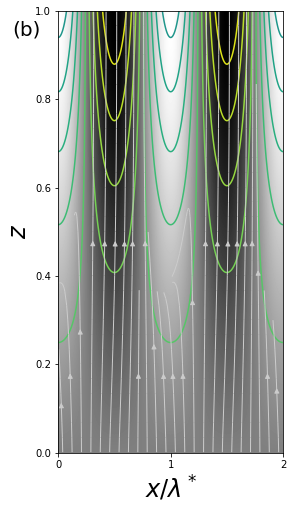

In [14]:
f, ax = plt.subplots()
zoom = 2.0
f.set_size_inches(9.8 * zoom, 4.06 * zoom)
f.set_facecolor('w')

plt.imshow(np.flipud(P), cmap='gray', extent=[0.0, 2.*lambda_, 0.0, 1.0])
cs = plt.contour(X, Z, phi, levels=np.linspace(-1, 1, 20))
# plt.clabel(cs, linewidth=1.5)

nlines = 24
h = 2.0 * lambda_/(nlines+1.0)
seed = np.zeros((nlines, 2))
seed[:, 0] = np.linspace(0.5*h, 2.0*lambda_-0.5*h, nlines)
seed[:, 1] = np.ones_like(seed[:, 0]) / 1000.0
plt.streamplot(X, Z, U, W, start_points=seed, integration_direction='forward', color=[0.8, 0.8, 0.8], linewidth=1)
# set(S,'color',[1 1 1]*0.8,'linewidth',1)
# set(gca,'ytick',[0 0.5 1],'xtick',[0 1 2-eps]*lambda);
# set(gca,'xticklabel',{'0','1','2'});
plt.xlabel(r'$x/\lambda^*$', fontsize=24)
plt.xlim(0, 2.*lambda_)
plt.xticks(ticks=(0, lambda_, 2*lambda_), labels=(0, 1, 2))
plt.ylabel(r'$z$', fontsize=24)
plt.ylim(0, 1)
plt.yticks((0, 0.5, 1))
plt.text(-0.04, 0.98, '(b)', fontsize=20, verticalalignment='top', horizontalalignment='right')
plt.show()

### The large-Damkohler number limit


### A modified problem and its analytical solution

## Application to the mantle